Downloading the trial records from OldBailey using the API

In [1]:
import requests
import os
import time
from google.colab import drive

#store text files
save_path = '/content/oldbailey'
os.makedirs(save_path, exist_ok=True)

# API endpoints
SEARCH_API = "https://www.dhi.ac.uk/api/data/oldbailey_record"
SINGLE_RECORD_API = "https://www.dhi.ac.uk/api/data/oldbailey_record_single"

#parameters
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3',
    'Accept': 'application/json'
}

def get_sample_ids(total_records=20):
    """Retrieve trial record IDs (starting with 't') from the API with pagination"""
    print("Fetching trial record IDs...")
    all_ids = []
    page_size = 10
    current_from = 0

    while len(all_ids) < total_records:
        params = {
            'size': page_size,
            'from': current_from,
            'text': '*'
        }

        response = requests.get(SEARCH_API, params=params, headers=headers)

        if response.status_code != 200:
            print(f"Error fetching IDs: {response.status_code}")
            break

        data = response.json()
        hits = data['hits']['hits']

        if not hits:
            break  # No more records

        # Extract only trial IDs (starting with 't') from current page
        page_ids = [
            hit['_source']['idkey']
            for hit in hits
            if hit['_source']['idkey'].startswith('t')
        ]
        all_ids.extend(page_ids)

        # Update pagination parameters
        current_from += page_size

        # Check if we've reached the requested total
        remaining = total_records - len(all_ids)
        if remaining <= 0:
            break

        # Adjust page size for final request if needed
        if remaining < page_size:
            page_size = remaining

        time.sleep(1)

    return all_ids[:total_records]  # Return exactly requested number

def save_records(record_ids):
    """Save individual records as xml files"""
    for i, record_id in enumerate(record_ids, 1):
        print(f"Downloading record {i}: {record_id}")
        params = {'idkey': record_id}

        try:
            response = requests.get(SINGLE_RECORD_API, params=params, headers=headers)
            if response.status_code == 200:
                data = response.json()
                text_content = data['hits']['hits'][0]['_source']['xml']

                # Clean filename and save
                safe_id = record_id.replace('/', '_')
                filename = os.path.join(save_path, f"{safe_id}.xml")
                with open(filename, 'w', encoding='utf-8') as f:
                    f.write(text_content)
                print(f"Successfully saved: {filename}")
            else:
                print(f"Failed to download {record_id} (Status: {response.status_code})")

            # Short pause between requests
            time.sleep(1)

        except Exception as e:
            print(f"Error processing {record_id}: {str(e)}")

#execution
sample_ids = get_sample_ids(40)  # Request number of trial records

if sample_ids:
    # print("\nFound these trial records:")
    # for id in sample_ids:
    #     print(f"- {id}")

    save_records(sample_ids)

    # # Optional: Save to Google Drive
    # drive.mount('/content/drive')
    # !cp -r {save_path} "/content/drive/MyDrive/"
    # print("\nFiles copied to Google Drive!")
else:
    print("No trial records found to download")

Fetching trial record IDs...
Successfully saved: /content/oldbailey/t16740429-1.xml
Successfully saved: /content/oldbailey/t16740429-2.xml
Successfully saved: /content/oldbailey/t16740429-3.xml
Successfully saved: /content/oldbailey/t16740429-4.xml
Successfully saved: /content/oldbailey/t16740429-5.xml
Successfully saved: /content/oldbailey/t16740429-6.xml
Successfully saved: /content/oldbailey/t16740429-7.xml
Successfully saved: /content/oldbailey/t16740429-8.xml
Successfully saved: /content/oldbailey/t16740429-9.xml
Successfully saved: /content/oldbailey/t16740717-1.xml
Successfully saved: /content/oldbailey/t16740717-2.xml
Successfully saved: /content/oldbailey/t16740717-3.xml
Successfully saved: /content/oldbailey/t16740717-4.xml
Successfully saved: /content/oldbailey/t16740717-5.xml
Successfully saved: /content/oldbailey/t16740717-6.xml
Successfully saved: /content/oldbailey/t16740909-1.xml
Successfully saved: /content/oldbailey/t16740909-2.xml
Successfully saved: /content/oldbail

**Sample inputs for 1 trial, 1 day, 1 month**

In [2]:

# Input for one trial
one_trial = ['/content/oldbailey/t16740429-7.xml']

# Input for one day (all trials on July 17, 1674)
one_day = [
    '/content/oldbailey/t16740717-1.xml',
    '/content/oldbailey/t16740717-2.xml',
    '/content/oldbailey/t16740717-3.xml',
    '/content/oldbailey/t16740717-4.xml',
    '/content/oldbailey/t16740717-5.xml',
    '/content/oldbailey/t16740717-6.xml'
]

# Input for one month (all trials in April 1674)
one_month = [
    '/content/oldbailey/t16740429-1.xml',
    '/content/oldbailey/t16740429-2.xml',
    '/content/oldbailey/t16740429-3.xml',
    '/content/oldbailey/t16740429-4.xml',
    '/content/oldbailey/t16740429-5.xml',
    '/content/oldbailey/t16740429-6.xml',
    '/content/oldbailey/t16740429-7.xml',
    '/content/oldbailey/t16740429-8.xml',
    '/content/oldbailey/t16740429-9.xml'
]

Parse the XML files

In [3]:
import os
import re
import xml.etree.ElementTree as ET
import time

def parse_trial(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    trial_data = {
        "defendants": [],
        "verdicts": []
    }

    defendant_genders = {}
    for pers in root.findall(".//persName[@type='defendantName']"):
        defendant_id = pers.get("id")  # Get the defendant's ID
        gender = pers.find("interp[@type='gender']")
        gender_value = gender.get("value") if gender is not None else "unknown"
        trial_data["defendants"].append(gender_value)
        defendant_genders[defendant_id] = gender_value

    # Extract guilty verdicts and associate them with defendant genders
    for verdict in root.findall(".//rs[@type='verdictDescription']"):
        if verdict.find("interp[@type='verdictCategory']").get("value") == "guilty":
            verdict_id = verdict.get("id")  # Get the verdict ID
            # Find the corresponding <join> element for this verdict
            for join_element in root.findall(".//join[@result='criminalCharge']"):
                targets = join_element.get("targets").split()
                if verdict_id in targets:

                    for target in targets:
                        if "defend" in target:  # Find the defendant ID in the targets
                            defendant_id = target
                            if defendant_id in defendant_genders:
                                trial_data["verdicts"].append(defendant_genders[defendant_id])

    return trial_data

Using Counter()  to count frequencies, kept it to see the time comparison




In [4]:
from collections import Counter

def count_frequencies_counter(trial_files):
    # Initialize counters
    all_defendants = []
    all_verdicts = []

    for file in trial_files:
        data = parse_trial(file)
        all_defendants.extend(data["defendants"])
        all_verdicts.extend(data["verdicts"])

    # Use Counter to count frequencies
    defendant_counter = Counter(all_defendants)
    verdict_counter = Counter(all_verdicts)

    # Format the results similar to the other functions
    defendant_counts = {
        "total": len(all_defendants),
        "male": defendant_counter["male"],
        "female": defendant_counter["female"]
    }

    verdict_counts = {
        "total": len(all_verdicts),
        "male": verdict_counter["male"],
        "female": verdict_counter["female"]
    }

    return defendant_counts, verdict_counts

Using Spark to count frequencies

In [5]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, when, lit

def count_frequencies_pyspark(trial_files):
    # Initialize Spark session
    spark = SparkSession.builder \
        .appName("Trial Analysis") \
        .master("local[*]") \
        .getOrCreate()

    # Lists to store all data
    all_defendants = []
    all_verdicts = []

    # Parse files and collect data
    for file in trial_files:
        data = parse_trial(file)
        all_defendants.extend(data["defendants"])
        all_verdicts.extend(data["verdicts"])

    # Create RDDs (Resilient Distributed Datasets)
    defendants_rdd = spark.sparkContext.parallelize(all_defendants)
    verdicts_rdd = spark.sparkContext.parallelize(all_verdicts)

    # Convert to DataFrames
    defendants_df = defendants_rdd.map(lambda x: (x,)).toDF(["gender"])
    verdicts_df = verdicts_rdd.map(lambda x: (x,)).toDF(["gender"])

    # Get total counts before filtering
    defendant_total = defendants_df.count()
    verdict_total = verdicts_df.count()

    # Filter DataFrames to include only 'male' and 'female' genders for gender counts
    defendants_filtered = defendants_df.filter((col("gender") == "male") | (col("gender") == "female"))
    verdicts_filtered = verdicts_df.filter((col("gender") == "male") | (col("gender") == "female"))

    # Count by gender for defendants
    defendant_counts = defendants_filtered.groupBy("gender").count().collect()

    # Count by gender for verdicts
    verdict_counts = verdicts_filtered.groupBy("gender").count().collect()

    # Format results as dictionary
    defendant_counts_dict = {"total": defendant_total}
    verdict_counts_dict = {"total": verdict_total}

    for row in defendant_counts:
        defendant_counts_dict[row["gender"]] = row["count"]

    for row in verdict_counts:
        verdict_counts_dict[row["gender"]] = row["count"]

    # Ensure male and female keys exist even if they're zero
    for gender in ["male", "female"]:
        if gender not in defendant_counts_dict:
            defendant_counts_dict[gender] = 0
        if gender not in verdict_counts_dict:
            verdict_counts_dict[gender] = 0

    # Stop the Spark session
    spark.stop()

    return defendant_counts_dict, verdict_counts_dict

Run the counter and visualize the runtime

In [6]:
inputs = [one_trial, one_day, one_month]

for input in inputs:
    print("Input:", (input))

    # Timing the Counter-based approach
    start_time_counter = time.time()
    defendant_counts_counter, verdict_counts_counter = count_frequencies_counter(input)
    time_counter = time.time() - start_time_counter

    # Timing the pandas-based approach
    start_time_spark = time.time()
    defendant_counts_pyspark, verdict_counts_pyspark = count_frequencies_pyspark(input)
    time_pandas = time.time() - start_time_spark

    print("\nDefendant counts (Counter):", defendant_counts_counter)
    print("Verdict counts (Counter):", verdict_counts_counter)
    print("Execution time (Counter):", time_counter, "seconds")

    print("\nDefendant counts (Spark):", defendant_counts_pyspark)
    print("Verdict counts (Spark):", verdict_counts_pyspark)
    print("Execution time (Spark):", time_pandas, "seconds")
    print("\n")

Input: ['/content/oldbailey/t16740429-7.xml']

Defendant counts (Counter): {'total': 2, 'male': 2, 'female': 0}
Verdict counts (Counter): {'total': 2, 'male': 2, 'female': 0}
Execution time (Counter): 0.0007777214050292969 seconds

Defendant counts (Spark): {'total': 2, 'male': 2, 'female': 0}
Verdict counts (Spark): {'total': 2, 'male': 2, 'female': 0}
Execution time (Spark): 17.794652700424194 seconds


Input: ['/content/oldbailey/t16740717-1.xml', '/content/oldbailey/t16740717-2.xml', '/content/oldbailey/t16740717-3.xml', '/content/oldbailey/t16740717-4.xml', '/content/oldbailey/t16740717-5.xml', '/content/oldbailey/t16740717-6.xml']

Defendant counts (Counter): {'total': 6, 'male': 5, 'female': 1}
Verdict counts (Counter): {'total': 5, 'male': 4, 'female': 1}
Execution time (Counter): 0.0012755393981933594 seconds

Defendant counts (Spark): {'total': 6, 'male': 5, 'female': 1}
Verdict counts (Spark): {'total': 5, 'male': 4, 'female': 1}
Execution time (Spark): 4.893850088119507 sec

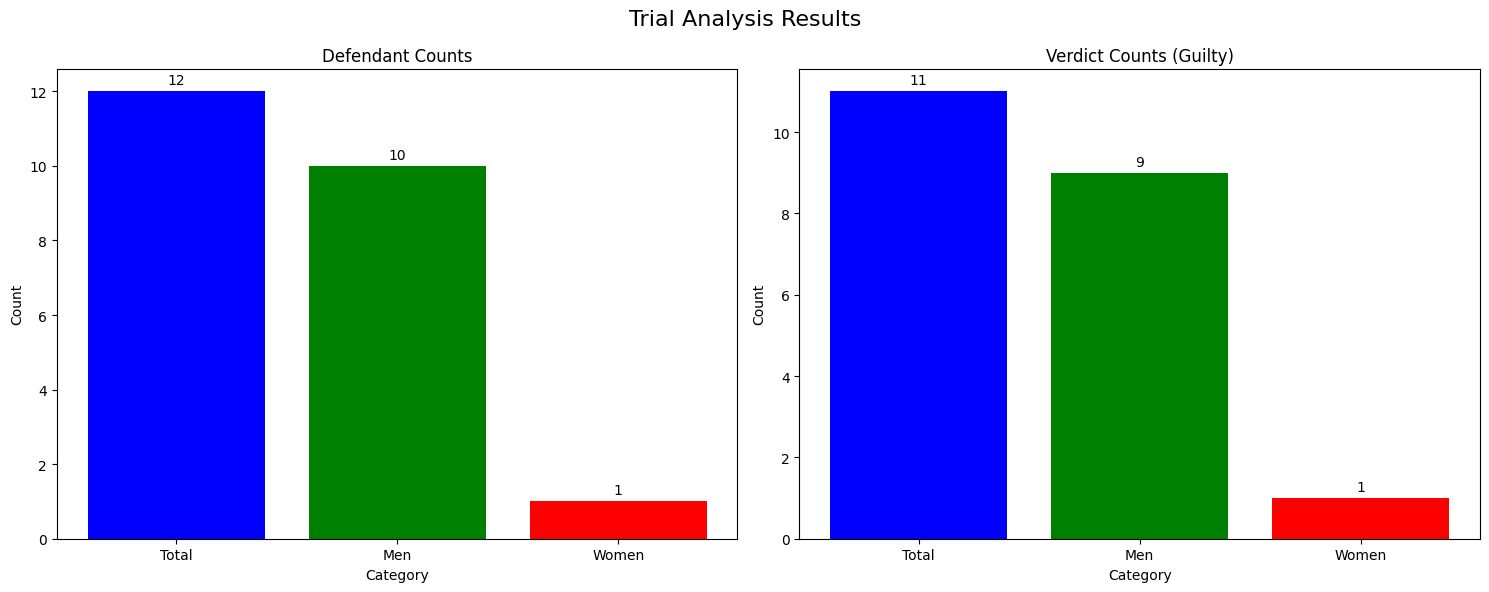

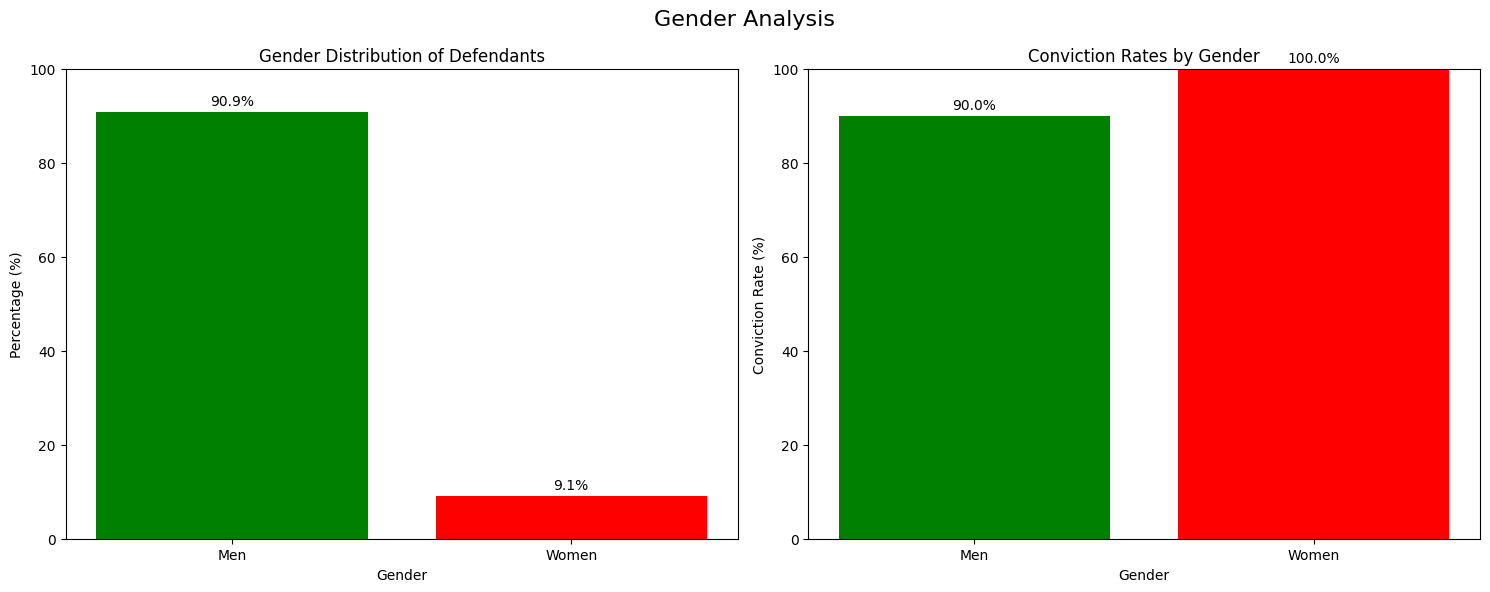

In [7]:
import matplotlib.pyplot as plt
import numpy as np

def plot_spark_data(defendant_counts_dict, verdict_counts_dict):

    # Extract values from dictionaries
    defendant_values = [
        defendant_counts_dict['total'],
        defendant_counts_dict['male'],
        defendant_counts_dict['female']
    ]

    verdict_values = [
        verdict_counts_dict['total'],
        verdict_counts_dict['male'],
        verdict_counts_dict['female']
    ]

    # Labels for the bars
    labels = ["Total", "Men", "Women"]

    # Set up the figure with two subplots side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Plot defendant counts
    bars1 = ax1.bar(labels, defendant_values, color=['blue', 'green', 'red'])
    ax1.set_title("Defendant Counts")
    ax1.set_xlabel("Category")
    ax1.set_ylabel("Count")

    # Add count labels on top of bars
    for bar in bars1:
        height = bar.get_height()
        ax1.annotate(f'{height}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

    # Plot verdict counts
    bars2 = ax2.bar(labels, verdict_values, color=['blue', 'green', 'red'])
    ax2.set_title("Verdict Counts (Guilty)")
    ax2.set_xlabel("Category")
    ax2.set_ylabel("Count")

    # Add count labels on top of bars
    for bar in bars2:
        height = bar.get_height()
        ax2.annotate(f'{height}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

    # Add a title for the entire figure
    plt.suptitle("Trial Analysis Results", fontsize=16)

    # Adjust layout
    plt.tight_layout()
    plt.subplots_adjust(top=0.88)

    # Show the plot
    plt.show()

    # Create a second figure with percentages
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Calculate percentages for male and female
    def_total_gender = defendant_counts_dict['male'] + defendant_counts_dict['female']
    def_male_pct = (defendant_counts_dict['male'] / def_total_gender * 100) if def_total_gender > 0 else 0
    def_female_pct = (defendant_counts_dict['female'] / def_total_gender * 100) if def_total_gender > 0 else 0

    ver_total_gender = verdict_counts_dict['male'] + verdict_counts_dict['female']
    ver_male_pct = (verdict_counts_dict['male'] / ver_total_gender * 100) if ver_total_gender > 0 else 0
    ver_female_pct = (verdict_counts_dict['female'] / ver_total_gender * 100) if ver_total_gender > 0 else 0

    # Calculate conviction rates by gender
    male_conviction_rate = (verdict_counts_dict['male'] / defendant_counts_dict['male'] * 100) if defendant_counts_dict['male'] > 0 else 0
    female_conviction_rate = (verdict_counts_dict['female'] / defendant_counts_dict['female'] * 100) if defendant_counts_dict['female'] > 0 else 0

    # Plot gender distribution percentages
    gender_labels = ["Men", "Women"]
    def_percentages = [def_male_pct, def_female_pct]
    bars3 = ax1.bar(gender_labels, def_percentages, color=['green', 'red'])
    ax1.set_title("Gender Distribution of Defendants")
    ax1.set_xlabel("Gender")
    ax1.set_ylabel("Percentage (%)")
    ax1.set_ylim(0, 100)

    #percentage labels
    for bar in bars3:
        height = bar.get_height()
        ax1.annotate(f'{height:.1f}%',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

    # Plot conviction rates by gender
    conviction_rates = [male_conviction_rate, female_conviction_rate]
    bars4 = ax2.bar(gender_labels, conviction_rates, color=['green', 'red'])
    ax2.set_title("Conviction Rates by Gender")
    ax2.set_xlabel("Gender")
    ax2.set_ylabel("Conviction Rate (%)")
    ax2.set_ylim(0, 100)

    # Add percentage labels
    for bar in bars4:
        height = bar.get_height()
        ax2.annotate(f'{height:.1f}%',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

    # Add a title for the percentage figure
    plt.suptitle("Gender Analysis", fontsize=16)

    # Adjust layout
    plt.tight_layout()
    plt.subplots_adjust(top=0.88)

    # Show the plot
    plt.show()

defendant_counts_dict, verdict_counts_dict = count_frequencies_pyspark(one_month)
plot_spark_data(defendant_counts_dict, verdict_counts_dict)